In [1]:
%pylab nbagg
from tvb.simulator.lab import *
import os.path
from matplotlib import colors, cm
import time
import scipy.signal as sig

import numpy as np
import pandas as pd
import scipy.io

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
2018-10-12 11:03:25,741 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO


# Things to Do
To turn this into a complete notebook that will generate my data systematically, I need to do the following:
1. Highlight the epileptor regions that are epileptic and PZ. In correspondence, print the region name and the electrodes that correspond to that region. 
2. Visualize where electrodes are in MRI cut? (Ask a labmate about that)
3. For each simulation, simulate 60 seconds of data. Cut off the first N seconds that are the model settling into it's fixed point. Save both epileptor and SEEG time series. For the beginning place electrode contact in center of region with EZ. Vary # EZ 1 - 3. Repeat simulation 5 times and save data. Run on fragility algorithm.

In [3]:
import numpy as np
from scipy.interpolate import interp1d
test = np.array(([1, 5, 6], [12, -3, 20], [10, 10, 10]))

# print test
# print sorted(enumerate(test), key=lambda x: x[1])
# print -np.sort(-test, axis=0)
indices = np.argsort(-test, axis=0)+1
print indices

interval = np.linspace(0, 2, 5)
interpmat = interp1d(np.arange(0,3), indices, kind='linear')
rankcent = interpmat(interval)
print rankcent

[[2 3 2]
 [3 1 3]
 [1 2 1]]
[[2.  2.5 3.  2.5 2. ]
 [3.  2.  1.  2.  3. ]
 [1.  1.5 2.  1.5 1. ]]


In [4]:
with h5py.File(filename, 'r') as infile:
    metadataset = infile['metadata']
    
    # extract datasets
    seegts = infile['seegts']
    epilepts = infile['epilepts']
    timepoints = infile['timepoints']
#     chanxyz = infile['chanxyz']
#     regionxyz = infile['regionxyz']
    
    seegts = seegts[...]
    epilepts = epilepts[...]
    timepoints = timepoints[...]
    
    metadata = dict()
    for attr in metadataset.attrs:
        metadata[str(attr)] = metadataset.attrs[attr]
filename = os.path.join(datadir, 'rb_simulated_1ez_2pz_01.hdf')
# open file for writing
with h5py.File(filename, 'w') as outfile:
    # write time series data and create a meta data container
    seegts = outfile.create_dataset('seegts', data=tsseeg)
    epits = outfile.create_dataset('epilepts', data=tsnodes)
    timepoints = outfile.create_dataset('timepoints', data=tpnodes)
    metadata = outfile.create_dataset('metadata', data=h5py.Empty("f"))
    
#     chanxyz = outfile.create_dataset('chanxyz')
    
    # set attributes
    metadata.attrs["pz"] = newpz
    metadata.attrs["ez"] = ez
    metadata.attrs['x0ez'] = x0['x0ez']
    metadata.attrs['x0pz'] = x0['x0pz']
    metadata.attrs['x0norm'] = x0['x0num']

chanxyz.to_hdf(filename, 'chanxyz', append=True)
regionxyz.to_hdf(filename, 'regionxyz', append=True)

NameError: name 'h5py' is not defined

In [5]:
root_dir = os.getcwd()
project_dir = os.path.join(root_dir, "data/")

print project_dir

/home/WIN/ali39/Documents/tng_tvb/notebook-sims/RB - Data Simulated/data/


# Connectivity
Get the connectivity of the model

In [3]:
con = connectivity.Connectivity.from_file(os.path.join(project_dir, "connectivity.zip"))
con.speed = np.inf

# normalize
con.weights = con.weights/np.max(con.weights)
num_regions = len(con.region_labels)

print con
print num_regions
print con.weights.shape

Connectivity(bound=False, value=None)
84
(84, 84)


<IPython.core.display.Javascript object>


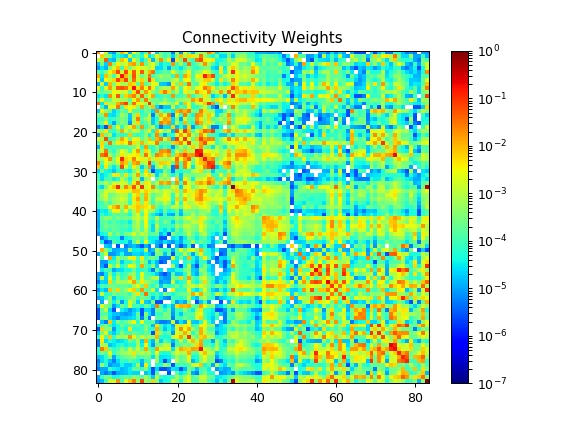

In [5]:
figure()
image = con.weights
norm = colors.LogNorm(1e-7, image.max()) #, clip='True')
imshow(image, norm=norm, cmap=cm.jet)
title('Connectivity Weights')
colorbar()
#max(con.weights[con.weights != 0])

# Model
Define our model to be the epileptor.

In [6]:
epileptors = models.Epileptor(variables_of_interest=['x1', 'y1', 'z', 'x2', 'y2', 'g', 'x2 - x1'])
epileptors.r = 0.0001
epileptors.Ks = np.ones(num_regions)*(-1.0)*20.0

In [7]:
# Patient specific modifications
ez = [9]
pz = [6, 27]

epileptors.x0 = np.ones(num_regions)*-2.3
epileptors.x0[ez] = -1.8
epileptors.x0[pz] = -2.05

# Coupling
Define a simple difference coupling with values all = 1.

In [8]:
coupl = coupling.Difference(a=1.)

# Integrator
Define an integration scheme

In [9]:
hiss = noise.Additive(nsig = numpy.array([0.01, 0.01, 0., 0.00015, 0.00015, 0.]))
heunint = integrators.HeunStochastic(dt=0.04, noise=hiss)
heunintdet = integrators.HeunDeterministic(dt=0.04)

print hiss

Additive(dt=None, ntau=0)


# Monitors

In [10]:
mon_tavg = monitors.TemporalAverage(period=1.0)
mon_SEEG = monitors.iEEG.from_file(sensors_fname=os.path.join(project_dir, "seeg.txt"),
                                   projection_fname=os.path.join(project_dir, "gain_inv-square.txt"),
                                   period=1.0,
                                   variables_of_interest=[0],
                                   )
num_contacts = mon_SEEG.sensors.labels.size

In [11]:
con.cortical[:] = True     # To avoid adding analytical gain matrix for subcortical sources

sim = simulator.Simulator(model=epileptors,
                          connectivity=con,
                          coupling=coupl,
                          conduction_speed=np.inf,                          
                          integrator=heunint,
                          monitors=[mon_tavg, mon_SEEG])

sim.configure()

initial_conditions,None
coupling,Difference(a=1)
stimulus,None
integrator,"HeunStochastic(dt=0.04, noise=Additive(dt=0.04, ntau=0))"
surface,None
connectivity,"Connectivity(bound=False, value=None)"
conduction_speed,inf
simulation_length,1000.0
model,"Epileptor(bound=False, value=None)"
monitors,"[TemporalAverage(bound=False, value=None), iEEG(bound=False, value=None)]"


In [12]:
sim_length = 10000 # every 1000 is 1 second
(ttavg, tavg), (tseeg, seeg) = sim.run(simulation_length=30000)

In [21]:
# understand the data output
print tavg.shape # the region time series 
print seeg.shape # the electrode time series
print num_contacts
print num_regions

(30000, 7, 84, 1)
(31250, 1, 162, 1)
162
84


In [13]:
# Normalize the time series to have nice plots
tavgn = tavg/(np.max(tavg, 0) - np.min(tavg, 0))
seegn = seeg/(np.max(seeg, 0) - np.min(seeg, 0))
seegn = seegn - np.mean(seegn, 0)

In [14]:
b, a = sig.butter(2, 0.1, btype='highpass', output='ba')
#seegf = sig.filtfilt(B, A, seegn)
seegf = np.zeros(seegn.shape)
for i in range(num_contacts):
    seegf[:, 0, i, 0] = sig.filtfilt(b, a, seeg[:, 0, i, 0])

# Visualize Meta and Simulated Data
1. Figure out where SEEG contacts are
2. Figure out where region centers are
3. Determine how to move contacts


In [58]:
seeg_locs_df = pd.read_csv('data/seeg.txt', delim_whitespace=1, \
                           names=['chan','x','y','z'])
region_locs_df = pd.read_csv('data/connectivity/centres.txt', delim_whitespace=1, \
                           names=['region_center','x','y','z'])  

print "The EZ region selected was: \n", region_locs_df.ix[ez]
display(seeg_locs_df.head())
display(region_locs_df.head())

The EZ region selected was: 
             region_center        x        y        z
9  ctx-lh-lateraloccipital -30.7486 -87.0365 -30.6099


,chan,x,y,z
0,TB'1,-26.63,0.70,-46.78
1,TB'2,-30.11,0.87,-46.46
2,TB'3,-33.59,1.05,-46.15
3,TB'4,-37.07,1.22,-45.84
4,TB'5,-40.55,1.40,-45.53


,region_center,x,y,z
0,ctx-lh-bankssts,-47.4046,-46.2536,-24.7605
1,ctx-lh-caudalanteriorcingulate,-3.8134,15.3589,7.5379
2,ctx-lh-caudalmiddlefrontal,-34.8053,6.1341,16.2457
3,ctx-lh-cuneus,-7.9202,-83.8659,-14.3875
4,ctx-lh-entorhinal,-25.0397,-6.3420,-49.7830


In [ ]:
# determine if there are SEEG contacts within this region
# find channels within x region

# find chans within y region

# find chans within z region

<IPython.core.display.Javascript object>


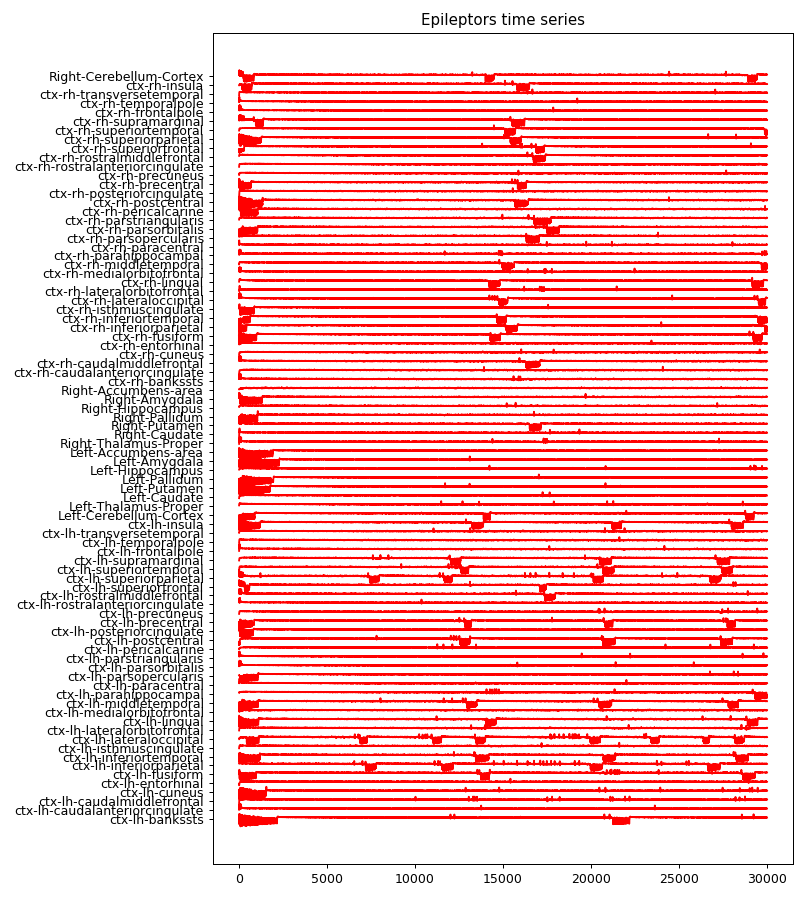

In [26]:
% matplotlib osx
#Plot raw time series
figure(figsize=(9,10))

indf = 0
indt = -1

regf = 0
regt = 84

plot(ttavg[indf:indt], tavg[indf:indt, 6, regf:regt, 0]/4 + np.r_[regf:regt], 'r')
yticks(np.r_[regf:regt], con.region_labels[regf:regt])
title("Epileptors time series")
tight_layout()
show()   

<IPython.core.display.Javascript object>


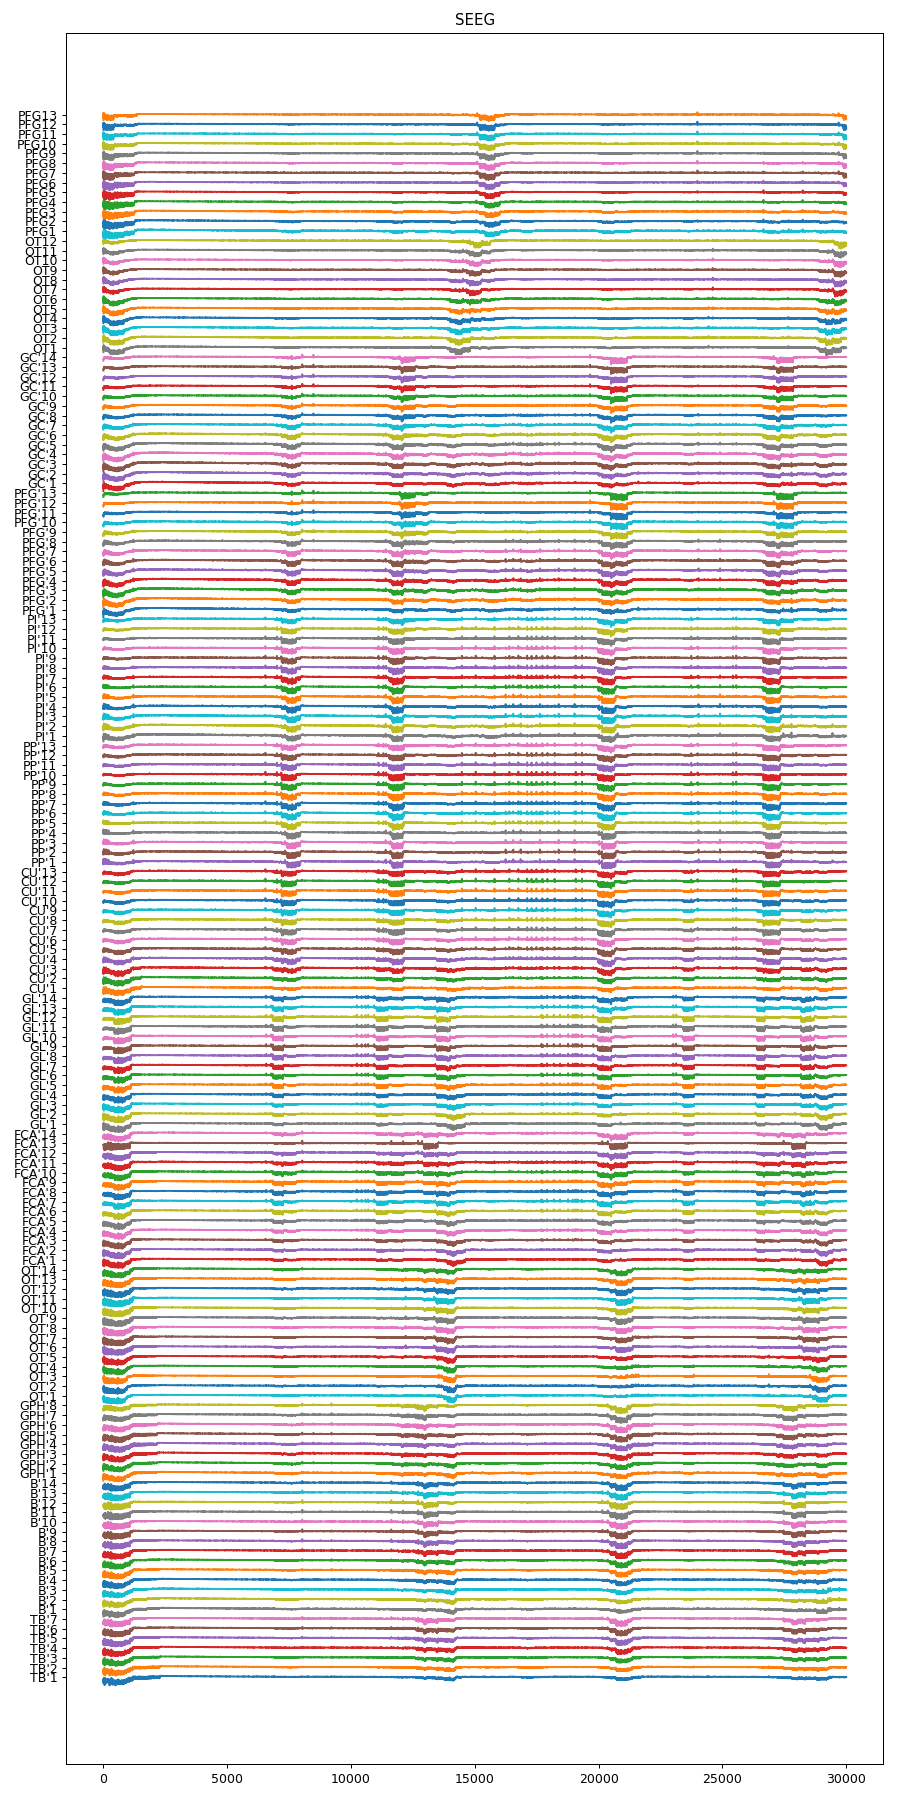

(31250, 1, 162, 1)


In [19]:
figure(figsize=(10,20))
plot(tseeg[:], seegn[:, 0, :, 0] + np.r_[:num_contacts])
yticks(np.r_[:num_contacts], mon_SEEG.sensors.labels[:])
title("SEEG")
tight_layout()

<IPython.core.display.Javascript object>


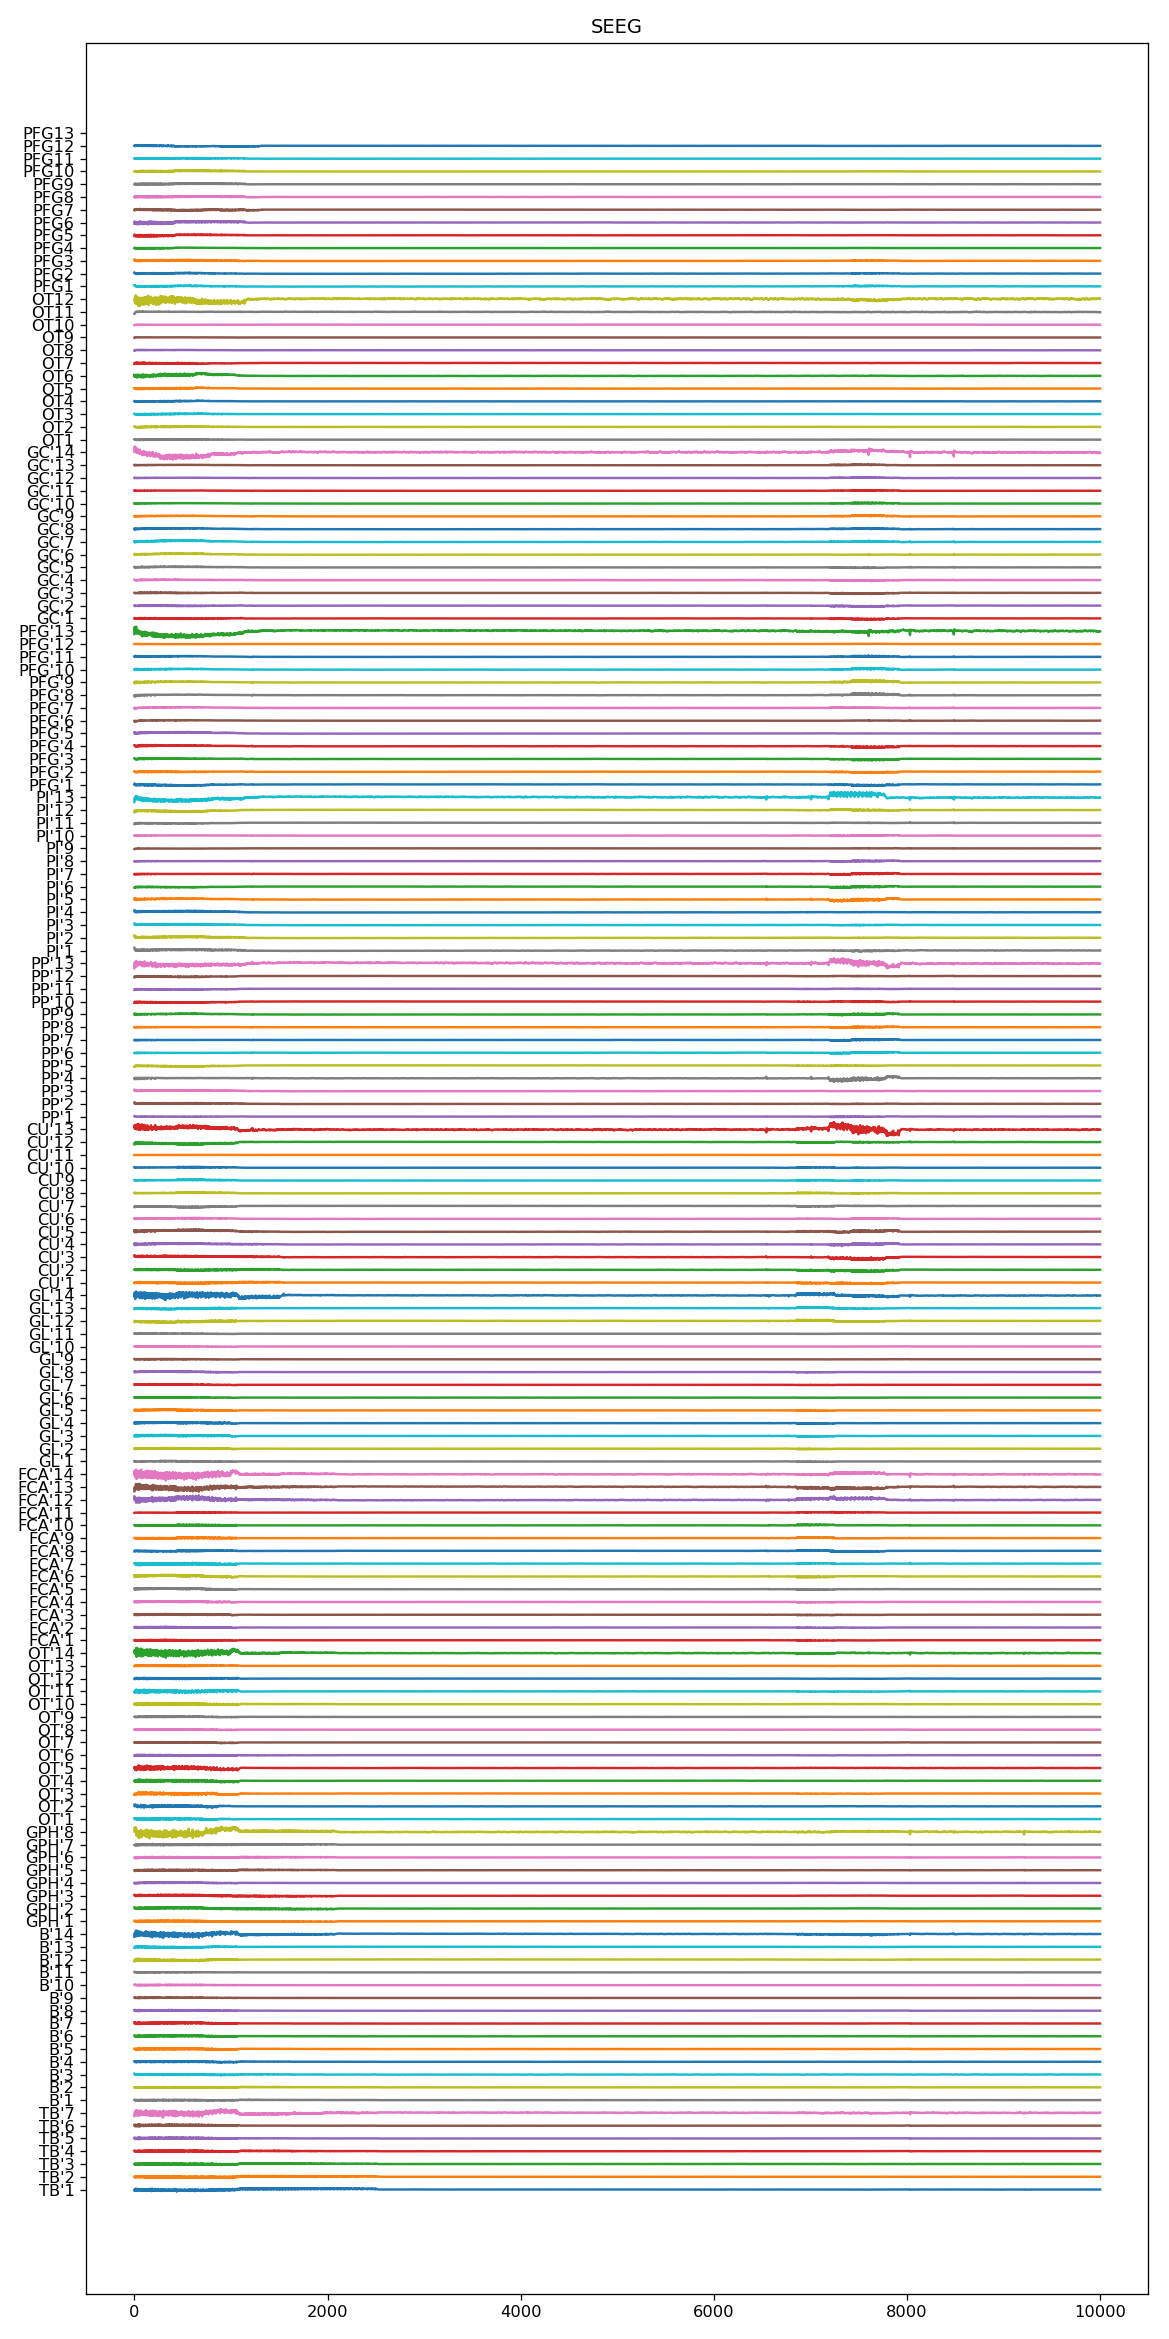

In [16]:
figure(figsize=(10,20))
plot(tseeg[:], (seegn[:, 0, 1:num_contacts, 0] - seegn[:, 0, 0:num_contacts-1, 0]) + np.r_[:num_contacts-1])
yticks(np.r_[:num_contacts], mon_SEEG.sensors.labels[:])
title("SEEG")
tight_layout()

<IPython.core.display.Javascript object>


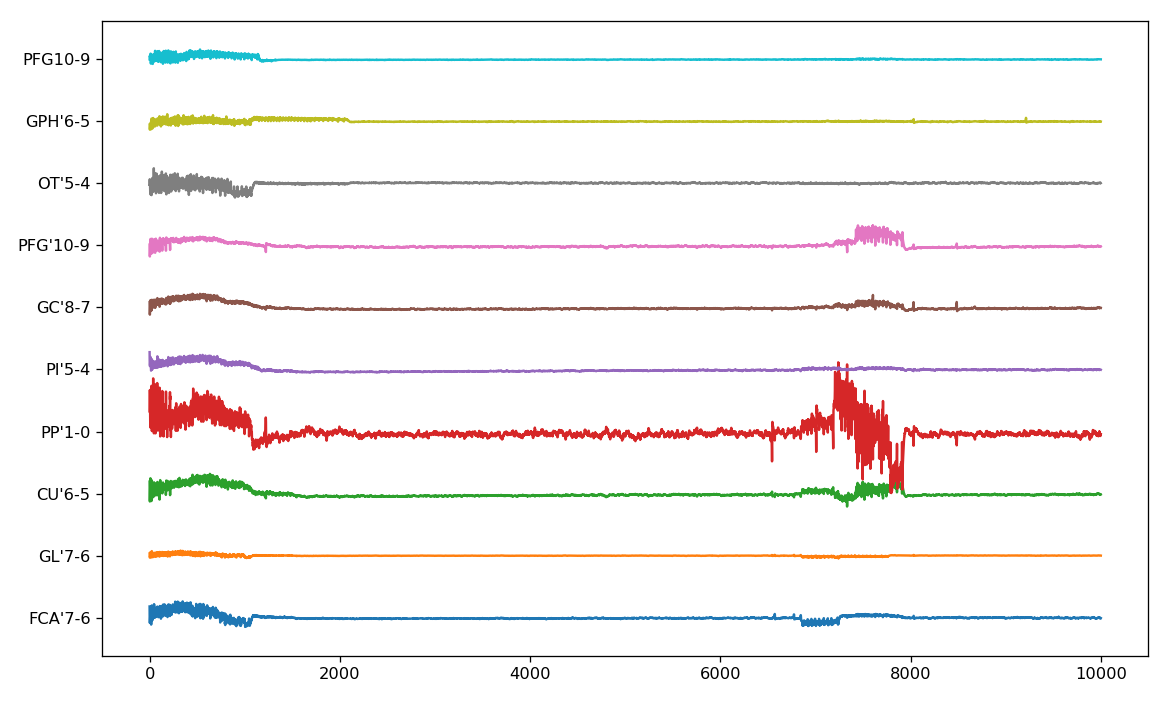

In [17]:
figure(figsize=(10, 6))

electrodes = [("FCA'", 7), ("GL'", 7), ("CU'", 6), ("PP'", 1),
              ("PI'", 5), ("GC'", 8), ("PFG'", 10),
              ("OT'", 5), ("GPH'", 6), ("PFG", 10)]


for i, (el, num) in enumerate(electrodes):
    ind = np.where(mon_SEEG.sensors.labels == el + str(num))[0][0]
    plot(tseeg[:], (seegn[:, 0, ind, 0] - seegn[:, 0, ind - 1, 0])/0.5 + i)

labels = [el[0] + str(el[1]) + "-" + str(el[1] - 1) for el in electrodes]
yticks(np.r_[:len(electrodes)], labels)
tight_layout()